<a href="https://colab.research.google.com/github/zndx1002070101/Python-Natural-Language-Processing/blob/main/guided_project_classifying_disaster_related_tweets_as_real_or_fake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.0 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


# Classifying Disaster-Related Tweets as Real or Fake

In this project, you’ll be working as a data scientist for a news analytics company interested in monitoring and analyzing news on social media platforms to look for misinformation. One of the most popular platforms is Twitter, which has become an important communication channel in times of emergency.

In this context, your company has given you a project in which they want you to build a deep learning text classification model that predicts which Tweets are about real disasters and which aren’

1. id: a unique identifier for each tweet

2. keyword: a particular keyword from the tweet (may be blank)

3. location: the location the tweet was sent from (may be blank)

4. text: the text of the tweet

5. target: denotes whether a tweet is about a real disaster (1) or not (0). This is the target variable.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import datasets
import transformers
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [ ]:
# Import the data
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/test.csv

--2023-10-12 16:39:33--  https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/train.csv
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.132.49, 52.216.51.225, 52.217.138.217, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.132.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.1s    

2023-10-12 16:39:33 (6.44 MB/s) - ‘train.csv’ saved [987712/987712]

--2023-10-12 16:39:33--  https://dsserver-prod-resources-1.s3.amazonaws.com/nlp/test.csv
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.132.49, 52.216.51.225, 52.217.138.217, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.132.49|:443... connec

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
train.shape

(7613, 5)

In [ ]:
test.shape

(3263, 4)

In [ ]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [ ]:
for col in train.columns:
  print("The number of unique values in {col_name} is {num}".format(col_name=col, num = len(train[col].unique())))

The number of unique values in id is 7613
The number of unique values in keyword is 222
The number of unique values in location is 3342
The number of unique values in text is 7503
The number of unique values in target is 2


Columns id and location has lots of null values and are related to the goal. It will be dropped.



## Data Exploration



In [ ]:
train_c = train.drop(['id', 'location'], axis=1)
test_c = test.drop(['id', 'location'], axis=1)

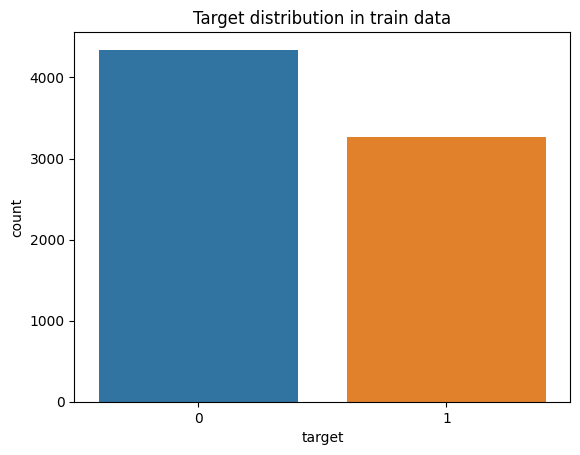

0    0.57034
1    0.42966
Name: target, dtype: float64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_c, x='target')
plt.title('Target distribution in train data')
plt.show()
train_c['target'].value_counts(normalize=True)

The ratio of target values of 1 is 0.43, disaster and non-disaster data is balanced.

## Text Preprocessing

In [ ]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
train_c['text'] = train_c['text'].str.lower()

In [ ]:
def clean_punct(data):
  return re.sub(r"[^\w\s]", ' ',data)

train_c['text'] = train_c['text'].apply(clean_punct)

In [ ]:
train_c['text'][:10]

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3    13 000 people receive  wildfires evacuation or...
4    just got sent this photo from ruby  alaska as ...
5     rockyfire update    california hwy  20 closed...
6     flood  disaster heavy rain causes flash flood...
7    i m on top of the hill and i can see a fire in...
8    there s an emergency evacuation happening now ...
9    i m afraid that the tornado is coming to our a...
Name: text, dtype: object

In [ ]:
# Tokenize
def tokenize(data):
  return word_tokenize(data)
train_c['tokenized'] = train_c['text'].apply(tokenize)

In [ ]:
train_c['text'].str.split(expand=True).stack().value_counts()

t              5199
co             4740
http           4309
the            3277
a              2200
               ... 
m7na4skfwr        1
orapinforma       1
214904            1
139055            1
ymy4rskq3d        1
Length: 21678, dtype: int64

In [ ]:
# remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['http', 'co', 'https', 'û_' ])
def stopwords_removal(data):
  return [word for word in data if word not in stop_words ]

train_c['stopwords_remv'] = train_c['tokenized'].apply(stopwords_removal)

In [ ]:
pd.Series(sum(train_c['stopwords_remv'], [])).value_counts()[:10]

like      348
amp       344
fire      254
get       229
new       226
via       220
2         215
people    200
news      197
one       196
dtype: int64

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatization(inputs):
  return [lemmatizer.lemmatize(word=word, pos='v') for word in inputs]

train_c['lemmaitzed'] = train_c['stopwords_remv'].apply(lemmatization)

<Axes: ylabel='Frequency'>

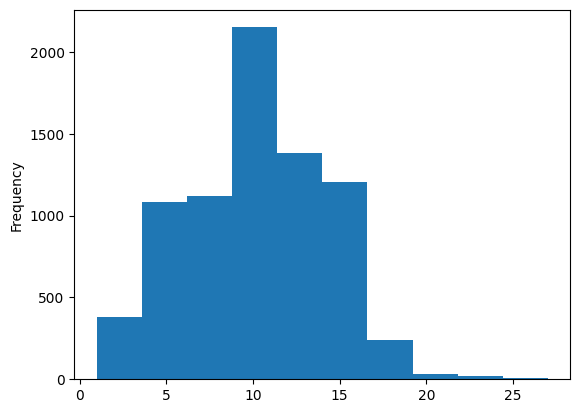

In [ ]:
train_c['lemmaitzed'].apply(len).plot.hist()

In [ ]:
train_c['final'] = train_c['lemmaitzed'].str.join(' ')
freq_10 = train_c['final'].str.split(expand=True).stack().value_counts()[:10]

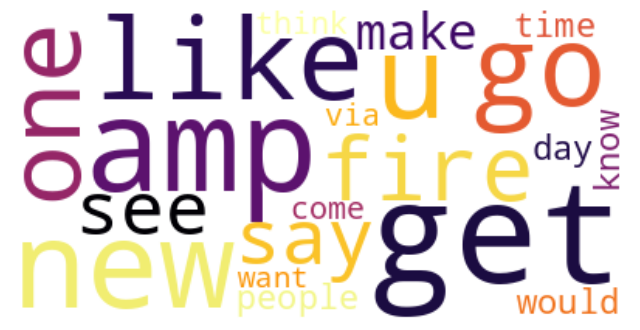

In [ ]:
from wordcloud import WordCloud
all_text = ' '.join(train_c['final'].tolist())
wc_1 = WordCloud(max_words=20, stopwords=stop_words,
                 random_state=100,
                 background_color='white',
                 colormap='inferno').generate(all_text)
plt.figure(figsize=(8, 6))
plt.imshow(wc_1, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
import plotly.express as px
fig1 = px.treemap(freq_10, path=[freq_10.index], values=0)
fig1.update_layout(title_text='Tree map of the 10 frequent used words', title_font=dict(size=20),
                   width=600,
                   height=400)
fig1.update_traces(textfont=dict(size=18))
fig1.show()

From the frequent words, it showed some words like 'fire', 'bomb' are related to the the disaster.

In [ ]:
freq_10_y = train_c[train_c.target==1]['final'].str.split(expand=True).stack().value_counts()[:10]
fig1 = px.treemap(freq_10_y, path=[freq_10_y.index], values=0)
fig1.update_layout(title_text='Top 10 frequent used words in disaster tweets', title_font=dict(size=20),
                   width=600,
                   height=400)
fig1.update_traces(textfont=dict(size=18))
fig1.show()

In [ ]:
freq_10_n = train_c[train_c.target==0]['final'].str.split(expand=True).stack().value_counts()[:10]
fig1 = px.treemap(freq_10_n, path=[freq_10_n.index], values=0)
fig1.update_layout(title_text='Top 10 frequent used words in non-disaster tweets', title_font=dict(size=20),
                   width=600,
                   height=400)
fig1.update_traces(textfont=dict(size=18))
fig1.show()

In disaster tweets, fire, bomb are the top 2 frequently used words. In non-disaster tweets, get and lik are the top 2 frequently used words.




## Build a Shallow Neural Network


In [ ]:
train_size = int(len(train)*0.8)
val_size = int(len(train)*0.1)
X = train['text']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=470)


In [ ]:
from tensorflow.keras.layers import TextVectorization
max_tokens = 25000
output_sequence_length = 256
tokenized_layer = TextVectorization(max_tokens = max_tokens,
                                    output_mode='int',
                                    standardize='lower_and_strip_punctuation',
                                    ngrams = (1, 2),
                                    output_sequence_length=output_sequence_length)

tokenized_layer.adapt(X_train)
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(input_dim=max_tokens,
                            output_dim=8,
                             input_length=output_sequence_length)




In [ ]:
y_train

3597    1
5947    0
6862    1
2797    1
7573    0
       ..
3940    0
919     0
5685    0
6849    0
856     0
Name: target, Length: 6090, dtype: int64

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam, RMSprop

model = Sequential()
# Input layer
model.add(Input(shape=(1,), dtype=tf.string))

# Add the tokenized and embedding layer
model.add(tokenized_layer)
model.add(embedding_layer)

# Hidden layer
model.add(layers.Dense(16, activation='relu'))
# Add the output layers
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = 'accuracy')

model.fit(X_train, y_train, epochs=3)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

Epoch 1/3
191/191 [==============================] - 36s 144ms/step - loss: 0.6844 - accuracy: 0.5754
Epoch 2/3
191/191 [==============================] - 10s 53ms/step - loss: 0.6775 - accuracy: 0.5866
Epoch 3/3
48/48 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5633
0.5633233189582825


Both the training and test data shows an accuracy 54%.


## Build a Multilayer Deep Text Classification Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import L1, L2, L1L2

model = Sequential()
# Input layer
model.add(Input(shape=(1,), dtype=tf.string))

# Add the tokenized and embedding layer
model.add(tokenized_layer)
model.add(embedding_layer)

# Add GlobalAveragePooling1D
model.add(layers.GlobalAveragePooling1D())

# Hidden layer
model.add(layers.Dense(64, activation='relu', kernel_regularizer=L1(0.01)))
# Add drop out
model.add(layers.Dropout(rate=0.4))

model.add(layers.Dense(64, activation='relu', kernel_regularizer=L2(0.01)))




# Add the output layers
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = 'accuracy')

model.fit(X_train, y_train, epochs=3)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

Epoch 1/3
191/191 [==============================] - 20s 95ms/step - loss: 1.2806 - accuracy: 0.5729
Epoch 2/3
191/191 [==============================] - 9s 47ms/step - loss: 0.7085 - accuracy: 0.5745
Epoch 3/3
48/48 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5535
0.5535128116607666


It doesn't show improvement

## Building a Multilayer Bidirectional LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import L1, L2, L1L2

model = Sequential()
# Input layer
model.add(Input(shape=(1,), dtype=tf.string))

# Add the tokenized and embedding layer
model.add(tokenized_layer)
model.add(embedding_layer)

# Add GlobalAveragePooling1D
# model.add(layers.GlobalAveragePooling1D())

# Add LSTM
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))

# Hidden layer
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, kernel_regularizer=L2(0.005))))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, kernel_regularizer=L1L2(0.005))))

# Add the output layers
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = 'accuracy')

model.fit(X_train, y_train, epochs=3)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

Epoch 1/3
191/191 [==============================] - 47s 161ms/step - loss: 5.5197 - accuracy: 0.7755
Epoch 2/3
191/191 [==============================] - 22s 114ms/step - loss: 0.6543 - accuracy: 0.7541
Epoch 3/3
48/48 [==============================] - 4s 33ms/step - loss: 0.6759 - accuracy: 0.7111
0.7110965251922607


## Building a Transformer Model

In [ ]:
import transformers
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')



In [ ]:
train_encoding = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encoding = tokenizer(X_test.tolist(), truncation=True, padding=True)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), tf.constant(y_train.values, dtype=tf.int32)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encoding), tf.constant(y_test.values, dtype=tf.int32)))
# train_dataset_ = train_dataset.shuffle(len(X_train)).batch(16)
# test_dataset_ = test_dataset.shuffle(len(X_test)).batch(16)
train_dataset_ = train_dataset.batch(16)
test_dataset_ = test_dataset.batch(16)

In [ ]:

from transformers import TFAutoModelForSequenceClassification

opt = Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.fit(train_dataset_, epochs=10)

test_loss, test_acc = model.evaluate(test_dataset_)
print(test_acc)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/10
381/381 [==============================] - 90s 174ms/step - loss: 0.4398 - accuracy: 0.8064
Epoch 2/10
381/381 [==============================] - 57s 149ms/step - loss: 0.3005 - accuracy: 0.8790
Epoch 3/10
381/381 [==============================] - 57s 150ms/step - loss: 0.1942 - accuracy: 0.9282
Epoch 4/10
381/381 [==============================] - 57s 151ms/step - loss: 0.1389 - accuracy: 0.9499
Epoch 5/10
381/381 [==============================] - 57s 150ms/step - loss: 0.1084 - accuracy: 0.9609
Epoch 6/10
381/381 [==============================] - 56s 148ms/step - loss: 0.0914 - accuracy: 0.9645
Epoch 7/10
381/381 [==============================] - 57s 149ms/step - loss: 0.0743 - accuracy: 0.9693
Epoch 8/10
381/381 [==============================] - 57s 149ms/step - loss: 0.0553 - accuracy: 0.9760
Epoch 9/10
381/381 [==============================] - 57s 149ms/step - loss: 0.0488 - accuracy: 0.9788
Epoch 10/10
96/96 [==============================] - 6s 48ms/step - loss:

Transformer model has higher accuracy of 80.6%.
Shallow neural network layer accuracy: 54%.
Using Bidirectional LSTM model accuracy: 71.1%